### Задание

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).  

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.  

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.  

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.  

Данные можно скачать [тут](https://disk.yandex.ru/d/v5-lEOh3BCIYoQ)

### Описание данных  

`order_id` - id заказа  
`delivery_time` - время доставки в минутах  
`district` - район доставки  
`experiment_group` - экспериментальная группа  

Сформулируем гипотезы:  
Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.  
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть.

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats 
import requests
from urllib.parse import urlencode

In [2]:
# скачиваем данные в папку со скриптом
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/v5-lEOh3BCIYoQ'                       # ссылка на данные

# получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('experiment_lesson_4.csv', 'wb') as f:
    f.write(download_response.content)

In [3]:
experiment = pd.read_csv('experiment_lesson_4.csv')

In [4]:
experiment.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
experiment.experiment_group.value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

In [6]:
experiment.district.value_counts()

Purlieus    16960
Central      2396
Suburb        840
Name: district, dtype: int64

In [7]:
experiment.experiment_group.value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

In [8]:
# тестовые и контрольные датафрэймы
control_df = experiment.query('experiment_group == "control"')
test_df    = experiment.query('experiment_group == "test"')

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

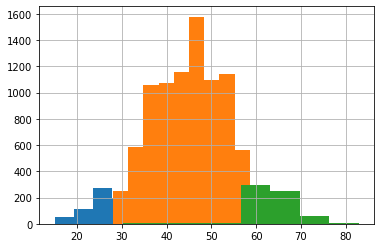

In [9]:
# график рапределения контрольной группы по районам
(
    control_df
        .groupby('district')
        .delivery_time
        .hist()
)

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

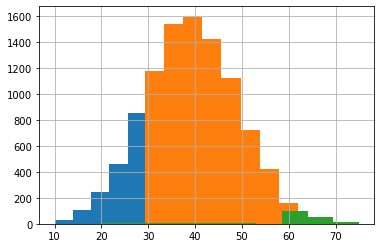

In [10]:
# график рапределения тестовой группы по районам
(
    test_df
        .groupby('district')
        .delivery_time
        .hist()
)

In [11]:
# количество наблюдейний
print('Количество наблюдений в тестовой группе:      ', len(test_df))
print('Количество наблюдений в контрольной группе:   ', len(control_df))
print('Разница вколичестве наблюдений в двух группах:', abs(len(test_df) - len(control_df)))

Количество наблюдений в тестовой группе:       10104
Количество наблюдений в контрольной группе:    10092
Разница вколичестве наблюдений в двух группах: 12


In [12]:
experiment[experiment['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)



17877    37.0
18499    39.0
16476    48.0
14602    30.0
16719    25.0
         ... 
12410    40.0
18882    47.0
15944    47.0
14618    41.0
18816    36.0
Name: delivery_time, Length: 1000, dtype: float64

Теперь изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тестовой группе и в контрольной.

In [13]:
# тест проверки на нормальность распределения Шапиро-Уилка, тестовая группа
stats.shapiro(
    test_df
        .delivery_time
        .sample(1000, random_state=17)  # семплирование тестовой группы
)

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)

In [14]:
# тест проверки на нормальность распределения Шапиро-Уилка, контрольная группа
stats.shapiro(
    control_df
        .delivery_time
        .sample(1000, random_state=17)  # семплирование тестовой группы
)

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

Так как нулевая гепотеза тест Шапиро-Уилка - "распределение нормальное", при p > 0,05 принимаем её.

In [15]:
# Стандартное отклонение времени доставки в тесте 
test_df.delivery_time.std().round(2)

9.88

In [16]:
# Стандартное отклонение времени доставки в контрольной группе
control_df.delivery_time.std().round(2)

9.99

In [17]:
# сравним средние с помощью теста Стьюдента
stats.ttest_ind(test_df.delivery_time, control_df.delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Принимаем альтернативную гипотизу - средние значения отличаются.

In [18]:
# на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной
'{:.2%}'.format(
    (test_df
        .delivery_time
        .mean()
    - 
     control_df
        .delivery_time.mean())
     /
     control_df
        .delivery_time
        .mean()
)

'-13.35%'

Вывод: раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.